Propagation d'incertitudes dans une chaîne de Markov
===

On considère une chaîne de Markov ainsi construite. 

L'état du système au début du n-ème saut est constitué d'un vecteur aléatoire $U$ ainsi que d'un vecteur déterministe $V$. 
Le vecteur aléatoire $U_n$ est ici constitué de trois variables aléatoires :
* $K_n$ de loi Gaussienne,
* $P_n$ de loi Gaussienne,
* $R_n$ de loi Weibull tronquée.

Le vecteur déterministe $V_n$ est constitué d'une variable déterministe :

* $y_n$.

L'état déterministe initial est donné par l'équation 
$$
y_0 = 0.
$$

A chaque saut de la chaîne de Markov, nous générons une réalisation du vecteur aléatoire $U_n$ et appliquons la fonction de transition $\Phi$ pour connaître la valeur du vecteur déterministe $V_{n+1}$. Dans notre application, on considère 3 sauts :
$$
N=3.
$$

Dans cette chaîne de Markov, l'état à la fin du n-ème saut est déterminé par la fonction de transition $\Phi$ :

$$
V_{n+1} = \Phi(U_n,V_n),
$$
pour $n=1,...,N$. 

Dans notre application, la fonction de transition est définie par :
$$
\Phi(U_n,V_n) = y + d(1-R)KP,
$$

où $d$ est une constante égale à 

$$
d = 12.
$$


Nous nous intéressons à la variable d'intérêt $y_3$, c'est à dire à la valeur de la variable $y_n$ au terme des 3 sauts. 

Nous considérons deux quantités d'intérêt :
* l'espérance de $y$ : $E(y)$,
* la probabilité que $y$ soit plus grande qu'un seuil donné : $P(y>y_{lim})$.

Dans notre application, nous considérons le seuil limite :
$$
y_{lim}=14.
$$

Une implémentation naïve de cette chaîne de Markov consisterait à générer des nombres aléatoires selon les lois prescrites, puis à appliquer itérativement la fonction de transition $\Phi$. L'objectif principal de ce document est de montrer comment utiliser OpenTURNS dans le but de clarifier la modélisation probabiliste. En particulier, l'idée principale consiste à  expliciter la dimension stochastique du problème : elle est égale à la dimension du vecteur aléatoire $U_n$ multipliée par le nombre de sauts $N$. 

Cette considération possède plusieurs avantages. 
* Elle rend beaucoup plus simple la simulation de Monte-Carlo.
* Elle permet d'utiliser d'autres types de plans d'expériences, comme les séquences à faible discrépance par exemple. 
* Elle permet d'utiliser d'autres types de méthodes, comme par exemple la méthode FORM pour l'estimation d'une probabilité de dépassement de seuil. 
* Elle peut améliorer la performance en laissant OpenTURNS gérer l'évaluation du plan d'expériences au lieu d'utiliser une boucle. 

In [1]:
#!/usr/bin/env python
# coding: utf-8
import openturns as ot
from openturns.viewer import View

Fonction de transition
---

Fonction qui permet d'aller de l'état courant à l'état suivant.

In [2]:
def myFunctionSingleStep(K, P, d, R): 
	y = (1-R)*d*K*P
	return y
d = 10.
K = 0.85
P = 2.
R = 0.45
y = myFunctionSingleStep(K, P, d, R)
y

9.35

Implémentation de la fonction qui génère la sortie en fonction des entrées.
-----
Implémentation naïve : on calcule la sortie par trois appels à la fonction myFunctionSingleStep.

In [3]:
def myFunctionChain_naive(X):
    y0 = 0.0 # Valeur initiale de la sortie
    d = 10.0 # Constante
    K1, P1, R1, K2, P2, R2, K3, P3, R3 = X
    y = y0 + myFunctionSingleStep(K1, P1, d, R1)
    y = y + myFunctionSingleStep(K2, P2, d, R2)
    y = y + myFunctionSingleStep(K3, P3, d, R3)
    return [y]


Implémentation factorisée : on réalise une boucle sur le nombre de sauts.

In [4]:
def myFunctionChain_factorisee(X):
    # Nombre de variables dans l'état
    nbVariablesEtat = 3 # K, P, R
    # Nombre de sauts dans la chaîne
    nbSauts = int(len(X) / nbVariablesEtat)
    y0 = 0.0 # Valeur initiale de la sortie
    d = 10.0 # Constante
    # Boucle sur les sauts
    y = y0
    for i in range(nbSauts):
        K = X[nbVariablesEtat*i]
        P = X[nbVariablesEtat*i+1]
        R = X[nbVariablesEtat*i+2]
        y = y + myFunctionSingleStep(K, P, d, R)
    return [y]



Distributions  des variables aléatoires $K$, $P$ et $R$: 
---

In [5]:
dist_K = ot.Normal()
dist_P = ot.Normal()
dist_R = ot.Weibull()
Rmin = 1.0
dist_R = ot.TruncatedDistribution(dist_R, Rmin, ot.TruncatedDistribution.UPPER)

Création du vecteur aléatoire
---

In [6]:
# Variable d'état aléatoire
randomState = [dist_K,dist_P,dist_R]
# Nombre de sauts
nbSauts = 3
# Création du vecteur aléatoire de la chaîne
dist_X = randomState * nbSauts
myDistribution = ot.ComposedDistribution(dist_X)

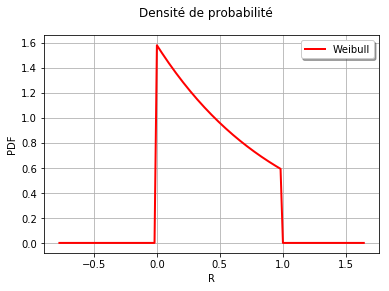

In [21]:
graph = dist_R.drawPDF()
graph.setLegends(['Weibull'])
graph.setTitle("Densité de probabilité")
graph.setXTitle("R")
View(graph)

Estimation de la sortie moyenne
---
On souhaite estimer la moyenne de la sortie par un plan d'expériences de type Monte-Carlo simple. 

On créée une fonction Python qui prend en entrée un vecteur en dimension 9 et évalue la sortie

In [8]:
# Nombre de variables dans l'état
nbVariablesEtat = 3 # K, P, R
# Nombre de sauts
nbSauts = 3
dim = nbVariablesEtat * nbSauts
functionPy = ot.PythonFunction(dim, 1, myFunctionChain_factorisee)

Création d'un RandomVector qui prend en entrée le vecteur aléatoire et évalue la sortie.

In [9]:
# create the event we want to estimate the probability
vect = ot.RandomVector(myDistribution)
G = ot.RandomVector(functionPy, vect)

In [10]:
# Estime la sortie moyenne
nbSim = 1000
outputSample = G.getSample(nbSim)
print("Sortie Moyenne = %f" % (outputSample.computeMean()[0]))

Sortie Moyenne = 0.030496


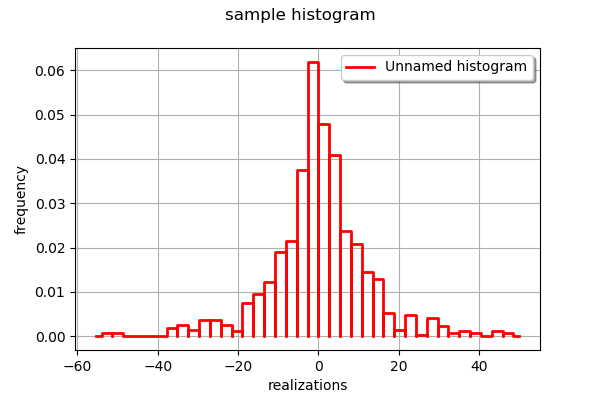

In [11]:
# Draw histogram
ot.VisualTest_DrawHistogram(outputSample)

Estimation de la sortie moyenne - plans d'expériences
---
On souhaite estimer la moyenne de la sortie et expérimenter différents plan d'expériences : Monte-Carlo simple et séquence de Sobol'.

In [12]:
Nbsimu = 1000
ot.RandomGenerator.SetSeed(1)
myDOE = ot.MonteCarloExperiment(myDistribution, Nbsimu)
mySample = myDOE.generate()
Y = ot.Sample(Nbsimu,1)
for rep in range(Nbsimu):
    Y[rep,0] = myFunctionChain_factorisee(mySample[rep,:])[0]


Calcul de la moyenne de la sortie

In [13]:
yMoyenne = Y.computeMean()[0]
print("Y moyenne : %f" % (yMoyenne))

Y moyenne : 0.272477


Pour utiliser une séquence à faible discrépance, il suffit de reprendre le script précédent avec le plan d'expérience suivant.

In [14]:
Nbsimu = 1000
sequence = ot.SobolSequence(9)
experiment = ot.LowDiscrepancyExperiment(sequence, myDistribution, Nbsimu)
experiment.setRandomize(True)
mySample = experiment.generate()

In [15]:
ot.RandomGenerator.SetSeed(1)
Y = ot.Sample(Nbsimu,1)
for rep in range(Nbsimu):
    Y[rep,0] = myFunctionChain_factorisee(mySample[rep,:])[0]

In [16]:
yMoyenne = Y.computeMean()[0]
print("Y moyenne : %f" % (yMoyenne))

Y moyenne : -0.643799


Estimation de la probabilité de dépasser un seuil
---

On souhaite estimer la probabilité que la sortie dépasse un seuil par une méthode de Monte-Carlo simple.

In [17]:
Y_limite = 14.
event = ot.Event(G, ot.Greater(), Y_limite)

In [18]:
# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.01)
algo.setBlockSize(100)
algo.setMaximumOuterSampling(int(nbSim))
algo.run()

In [19]:
# retrieve results
result = algo.getResult()
probability = result.getProbabilityEstimate()
print('P(Y > Y_limite)=', probability)

P(Y > Y_limite)= 0.08165999999999989


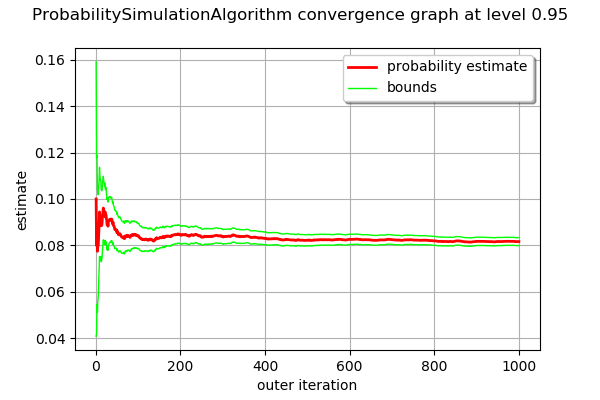

In [20]:
algo.drawProbabilityConvergence()